Datos de jugadores (common_player_info):
   person_id first_name     last_name   display_first_last  \
0      76001       Alaa     Abdelnaby       Alaa Abdelnaby   
1      76002       Zaid    Abdul-Aziz      Zaid Abdul-Aziz   
2      76003     Kareem  Abdul-Jabbar  Kareem Abdul-Jabbar   
3        949    Shareef   Abdur-Rahim  Shareef Abdur-Rahim   
4      76006     Forest          Able          Forest Able   

  display_last_comma_first  display_fi_last          player_slug  \
0          Abdelnaby, Alaa     A. Abdelnaby       alaa-abdelnaby   
1         Abdul-Aziz, Zaid    Z. Abdul-Aziz      zaid-abdul-aziz   
2     Abdul-Jabbar, Kareem  K. Abdul-Jabbar  kareem-abdul-jabbar   
3     Abdur-Rahim, Shareef   S. Abdur-Rahim  shareef-abdur-rahim   
4             Able, Forest          F. Able          forest-able   

             birthdate            school country  ...  \
0  1968-06-24 00:00:00              Duke     USA  ...   
1  1946-04-07 00:00:00        Iowa State     USA  ...   
2  194

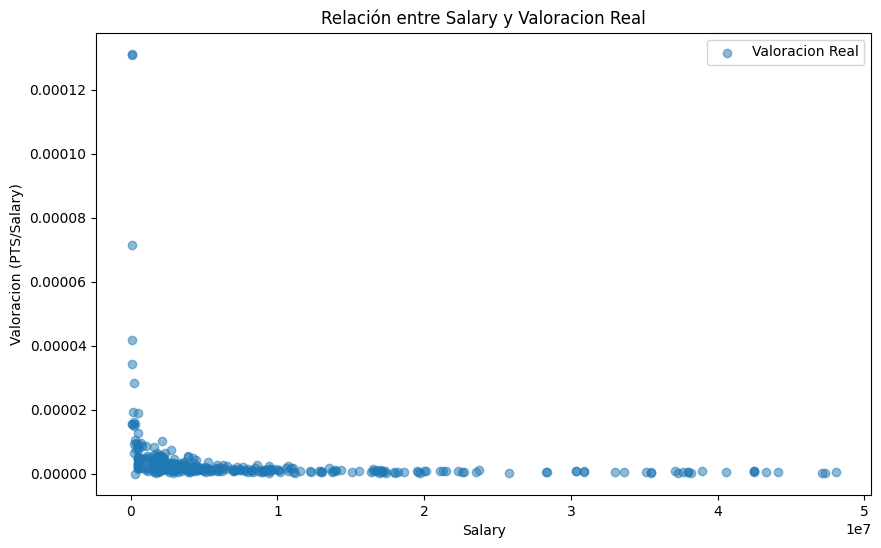

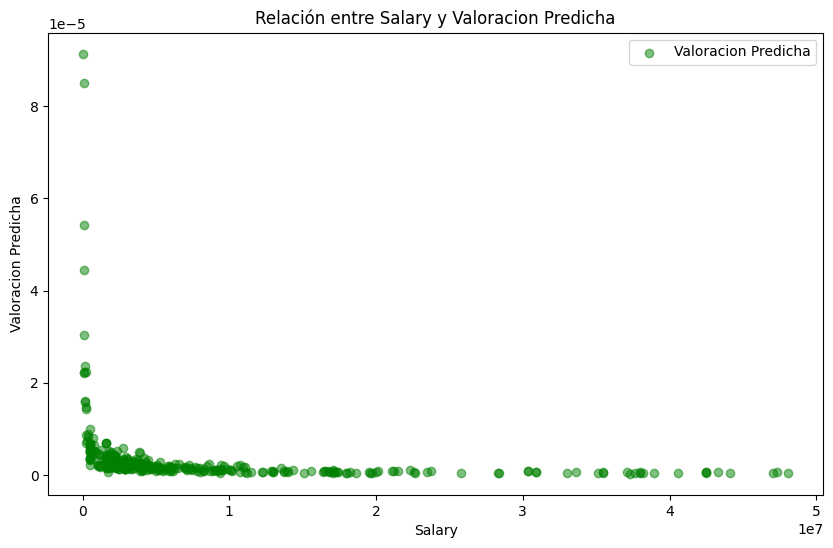


Sugerencia de jugadores subvalorados para la posición: Guard-Forward
first_name last_name Team      position  Age  season_exp  Salary  PTS  valoracion  predicted_valoracion Posicion_Requerida
       Max     Strus  MIA Guard-Forward   26         4.0 1815677 11.5    0.000006              0.000005      Guard-Forward
        PJ    Dozier  SAC Guard-Forward   26         6.0  784654  1.4    0.000002              0.000005      Guard-Forward
    Andrew  Nembhard  IND Guard-Forward   23         1.0 2244111  9.5    0.000004              0.000004      Guard-Forward
     Shake    Milton  PHI Guard-Forward   26         5.0 1997718  8.4    0.000004              0.000004      Guard-Forward
   Kenrich  Williams  OKC Guard-Forward   28         5.0 2000000  8.0    0.000004              0.000004      Guard-Forward
------------------------------------------------------------

Sugerencia de jugadores subvalorados para la posición: Forward-Center
first_name      last_name    Team       position  Age  seaso

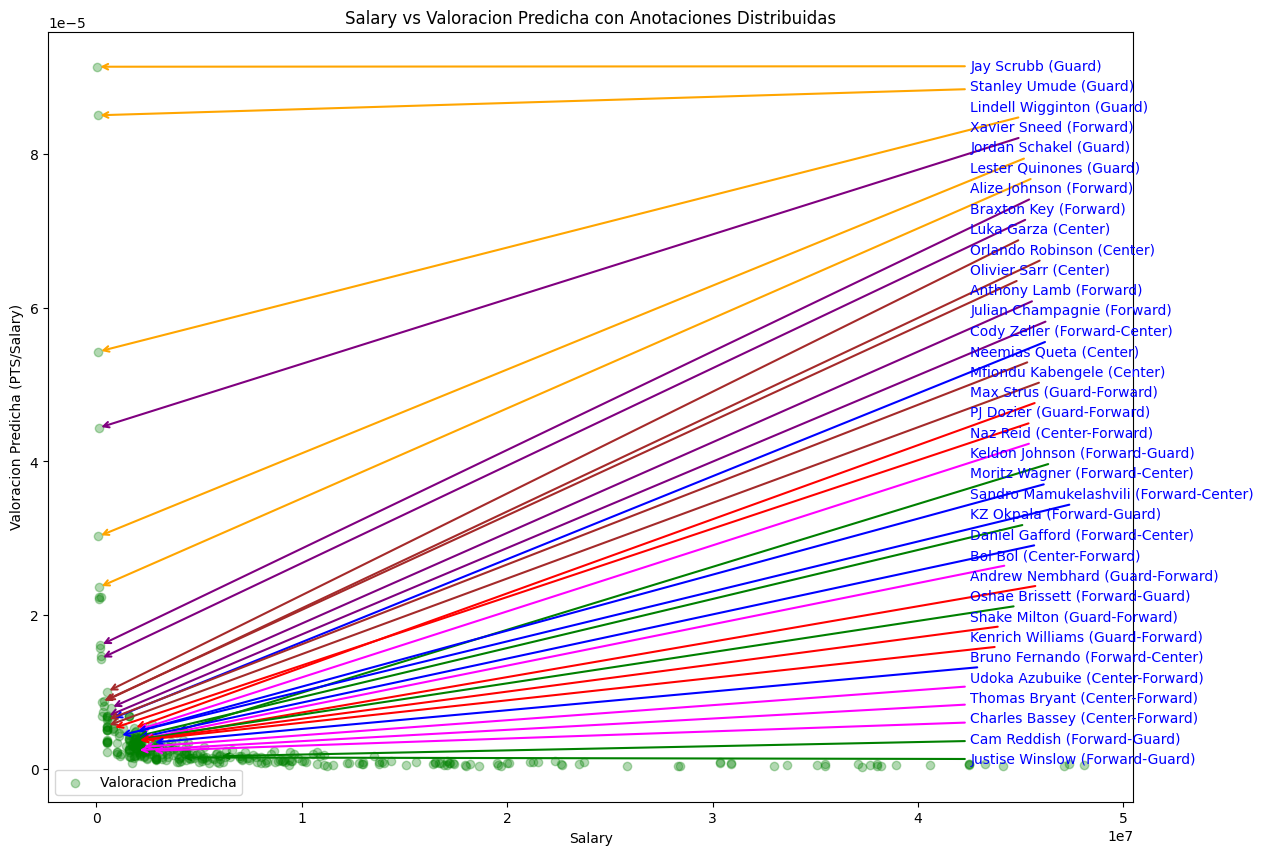

In [ ]:
#!/usr/bin/env python
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def load_data():
    # Ruta de la base de datos SQLite
    db_path = # Ingresa Ruta de la base de datos SQLite
    conn = sqlite3.connect(db_path)
    # Extraer la tabla common_player_info
    players_query = "SELECT * FROM common_player_info"
    players_df = pd.read_sql_query(players_query, conn)
    # Extraer la tabla nba_salaries
    salary_query = "SELECT * FROM nba_salaries"
    salary_df = pd.read_sql_query(salary_query, conn)
    conn.close()
    return players_df, salary_df

def main():
    # 1. Cargar los datos
    players_df, salary_df = load_data()
    print("Datos de jugadores (common_player_info):")
    print(players_df.head())
    print("\nDatos salariales (nba_salaries):")
    print(salary_df.head())
    
    # 2. Unir las tablas mediante sus identificadores
    players_df['person_id'] = pd.to_numeric(players_df['person_id'], errors='coerce')
    salary_df['player_id'] = pd.to_numeric(salary_df['player_id'], errors='coerce')
    data = pd.merge(players_df, salary_df, left_on='person_id', right_on='player_id', how='inner')
    
    # 3. Eliminar filas con valores nulos en columnas clave (Salary, PTS)
    data = data.dropna(subset=['Salary', 'PTS'])
    
    # 4. Convertir y limpiar columnas importantes (Salary, PTS, season_exp, Age, position)
    data['Salary'] = pd.to_numeric(data['Salary'], errors='coerce')
    data['PTS'] = pd.to_numeric(data['PTS'], errors='coerce')
    data['season_exp'] = pd.to_numeric(data['season_exp'], errors='coerce')
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    data['position_clean'] = data['position'].astype(str).str.strip()
    
    # 5. Calcular la métrica "valoracion": PTS/Salary (evitando división por cero)
    data['valoracion'] = data['PTS'] / (data['Salary'] + 1e-6)
    
    # 6. Preparar el conjunto de características para el modelo supervisado
    features_df = data[['Age', 'season_exp', 'Salary']].copy()
    positions_dummies = pd.get_dummies(data['position_clean'], prefix='pos')
    features_df = pd.concat([features_df, positions_dummies], axis=1)
    
    # 7. Variable objetivo: la "valoracion"
    target = data['valoracion']
    
    # 8. División en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)
    
    # 9. Entrenar un modelo RandomForestRegressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # 10. Evaluar el modelo
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("\nDesempeño del modelo de regresión:")
    print("R^2:", r2)
    print("MSE:", mse)
    
    # 11. Predecir "valoracion" para todos los jugadores y agregar la columna al DataFrame
    data['predicted_valoracion'] = model.predict(features_df)
    
    # 12. Graficar la relación entre Salary y la valoración real
    plt.figure(figsize=(10,6))
    plt.scatter(data['Salary'], data['valoracion'], alpha=0.5, label='Valoracion Real')
    plt.xlabel('Salary')
    plt.ylabel('Valoracion (PTS/Salary)')
    plt.title('Relación entre Salary y Valoracion Real')
    plt.legend()
    plt.show()
    
    # Graficar la relación entre Salary y la valoración predicha
    plt.figure(figsize=(10,6))
    plt.scatter(data['Salary'], data['predicted_valoracion'], color='green', alpha=0.5, label='Valoracion Predicha')
    plt.xlabel('Salary')
    plt.ylabel('Valoracion Predicha')
    plt.title('Relación entre Salary y Valoracion Predicha')
    plt.legend()
    plt.show()
    
    # 13. Sugerir 5 jugadores subvalorados por posición y mostrar resultados por posición
    required_positions = ["Guard-Forward", "Forward-Center", "Forward-Guard", "Guard", "Forward", "Center", "Center-Forward"]
    arrow_colors = {
        "Guard-Forward": "red",
        "Forward-Center": "blue",
        "Forward-Guard": "green",
        "Guard": "orange",
        "Forward": "purple",
        "Center": "brown",
        "Center-Forward": "magenta"
    }
    
    for pos in required_positions:
        subset = data[data['position_clean'].str.lower() == pos.lower()].copy()
        if subset.empty:
            print(f"\nNo se encontraron jugadores para la posición: {pos}")
            continue
        median_salary = subset['Salary'].median()
        subset_low = subset[subset['Salary'] < median_salary]
        if subset_low.empty:
            subset_low = subset
        top5 = subset_low.sort_values('predicted_valoracion', ascending=False).head(5).copy()
        top5['Posicion_Requerida'] = pos
        print(f"\nSugerencia de jugadores subvalorados para la posición: {pos}")
        cols_to_show = ['first_name', 'last_name', 'Team', 'position', 'Age', 'season_exp', 'Salary', 'PTS', 'valoracion', 'predicted_valoracion', 'Posicion_Requerida']
        print(top5[cols_to_show].to_string(index=False))
        print("-" * 60)
    
    # 14. Graficar scatter plot de Salary vs Valoracion Predicha con anotaciones distribuidas a lo largo del área interna
    plt.figure(figsize=(14,10))
    plt.scatter(data['Salary'], data['predicted_valoracion'], color='green', alpha=0.3, label='Valoracion Predicha')
    plt.xlabel('Salary')
    plt.ylabel('Valoracion Predicha (PTS/Salary)')
    plt.title('Salary vs Valoracion Predicha con Anotaciones Distribuidas')
    plt.legend()
    
    ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Definir límites internos para la zona de anotaciones (dentro de la gráfica)
    lower_bound = y_min + 0.05*(y_max - y_min)
    upper_bound = y_max - 0.05*(y_max - y_min)
    
    # Distribuir las anotaciones verticalmente: usar tantos espacios como anotaciones
    anno_list = []
    for pos in required_positions:
        subset = data[data['position_clean'].str.lower() == pos.lower()].copy()
        if subset.empty:
            continue
        median_salary = subset['Salary'].median()
        subset_low = subset[subset['Salary'] < median_salary]
        if subset_low.empty:
            subset_low = subset
        top5 = subset_low.sort_values('predicted_valoracion', ascending=False).head(5)
        for idx, row in top5.iterrows():
            # Agregar junto al nombre la posición
            anno_list.append((row['Salary'], row['predicted_valoracion'], f"{row['first_name']} {row['last_name']} ({row['position']})", pos))
    
    # Ordenar por predicted_valoracion descendente
    anno_list.sort(key=lambda x: x[1], reverse=True)
    n_annos = len(anno_list)
    
    if n_annos > 1:
        spacing = (upper_bound - lower_bound) / (n_annos - 1)
    else:
        spacing = (upper_bound - lower_bound)
    
    # Fijar la coordenada x para las anotaciones en una fracción del eje (dentro del gráfico)
    fixed_x = x_min + 0.85*(x_max - x_min)
    
    for i, (sal, pred_val, name, pos) in enumerate(anno_list):
        text_y = upper_bound - i * spacing
        color_arrow = arrow_colors.get(pos, "black")
        # Anotar: el texto (nombre y posición) se coloca en (fixed_x, text_y) y se dibuja una flecha recta al punto (sal, pred_val)
        plt.annotate(name,
                     xy=(sal, pred_val),
                     xytext=(fixed_x, text_y),
                     textcoords='data',
                     arrowprops=dict(arrowstyle="->", color=color_arrow, lw=1.5, connectionstyle="arc3,rad=0.0"),
                     fontsize=10, color='blue')
    
    plt.show()
    
if __name__ == '__main__':
    main()
